In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sportsipy.ncaab.teams import Teams
from sklearn.cluster import KMeans
import datetime

In [2]:
big_ten_teams = []
for team in Teams():
    if (team.conference == 'big-ten'):
        big_ten_teams.append(team)

In [4]:
def get_player_stats(teams: list, issue_players = []) -> pd.DataFrame:
    df = pd.DataFrame()
    for team in big_ten_teams:
        print(f"Adding {team.name} players...")
        for player in team.roster.players:
            try:
                player_stats = player.dataframe.loc['2021-22']
                player_stats.insert(0, 'name', player.name)
                df = pd.concat([df, player_stats])
            except:
                issue_players.append(player)
    return df

issue_players = []
df = get_player_stats(big_ten_teams, issue_players)

# Use this code to import directly from the dataset (faster)
# df = pd.read_csv('data/player_stats.csv', index_col='Unnamed: 0')

Adding Illinois players...
Adding Indiana players...
Adding Iowa players...
Adding Maryland players...
Adding Michigan State players...
Adding Michigan players...
Adding Minnesota players...
Adding Nebraska players...
Adding Northwestern players...
Adding Ohio State players...
Adding Penn State players...
Adding Purdue players...
Adding Rutgers players...
Adding Wisconsin players...


In [5]:
print(f"{len(issue_players)} players unable to be added: {issue_players}")

24 players unable to be added: [Shaan Burke (shaan-burke-1), Sebastien Scott (sebastien-scott-1), Michael Shipp (michael-shipp-2), Carter Kingsbury (carter-kingsbury-1), Ike Cornish (ike-cornish-1), Peter Nwoke (peter-nwoke-1), Jason Whitens (jason-whitens-1), Will Tschetter (will-tschetter-1), Brandon Wade (brandon-wade-1), Parker Fox (parker-fox-2), Isaiah Ihnen (isaiah-ihnen-1), Jackson Purcell (jackson-purcell-1), Sam Hoiberg (sam-hoiberg-1), Oleg Kojenets (oleg-kojenets-2), Quaran McPherson (quaran-mcpherson-1), Jace Piatkowski (jace-piatkowski-1), Kalen Etzler (kalen-etzler-1), Seth Towns (seth-towns-1), Trey Kaufman-Renn (trey-kaufman-renn-1), Brian Waddell (brian-waddell-1), Andrew Fulin (andrew-fulin-1), Logan Stephens (logan-stephens-1), Chris Hodges (chris-hodges-1), Matthew Mors (matthew-mors-1)]


In [6]:
player_df = df.reset_index(drop=True)

In [7]:
# Filter players by at least 10 games and 50 minutes played
player_df = player_df[(player_df['games_played'] >= 10) & (player_df['minutes_played'] >= 50)]

# Drop irrelevant and completely empty (non-null count = 0) columns
player_df = player_df.drop(['conference', 'height', 'player_id', 'team_abbreviation', 'weight'], axis=1)

# If a player has a missing 3FG%, it means they have 0 3FGA, so fill with 0
player_df['three_point_percentage'] = player_df['three_point_percentage'].fillna(0)

# One-hot encode the 'position' column
player_df['position'] = player_df['position'].apply(str.lower)
ohe = pd.get_dummies(player_df['position'], prefix='is')
player_df = player_df.drop('position', axis=1)
player_df = player_df.join(ohe)

In [8]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 195
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   name                             154 non-null    object 
 1   assist_percentage                154 non-null    float64
 2   assists                          154 non-null    int64  
 3   block_percentage                 154 non-null    float64
 4   blocks                           154 non-null    int64  
 5   box_plus_minus                   154 non-null    float64
 6   defensive_box_plus_minus         154 non-null    float64
 7   defensive_rebound_percentage     154 non-null    float64
 8   defensive_rebounds               154 non-null    int64  
 9   defensive_win_shares             154 non-null    float64
 10  effective_field_goal_percentage  154 non-null    object 
 11  field_goal_attempts              154 non-null    int64  
 12  field_goal_percentage 

In [9]:
player_df.head()

,name,assist_percentage,assists,block_percentage,blocks,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,...,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,win_shares,win_shares_per_40_minutes,is_center,is_forward,is_guard
0,Kofi Cockburn,6.6,22,3.0,27,9.3,2.0,25.6,201,1.8,...,65,381,0.593,226,32.0,5.3,0.247,1,0,0
1,Alfonso Plummer,7.1,35,0.0,0,4.7,0.4,7.7,70,1.0,...,43,123,0.455,56,22.8,3.7,0.150,0,0,1
2,Trent Frazier,21.8,126,0.4,4,5.6,3.0,7.1,70,1.4,...,55,113,0.513,58,18.4,3.6,0.135,0,0,1
3,Jacob Grandison,17.9,69,0.6,5,7.0,2.0,12.0,82,0.9,...,37,90,0.522,47,18.7,3.0,0.159,0,0,1
4,Coleman Hawkins,14.8,50,2.6,17,6.1,4.2,16.4,94,1.2,...,45,89,0.551,49,18.4,2.1,0.133,0,1,0


<AxesSubplot:>

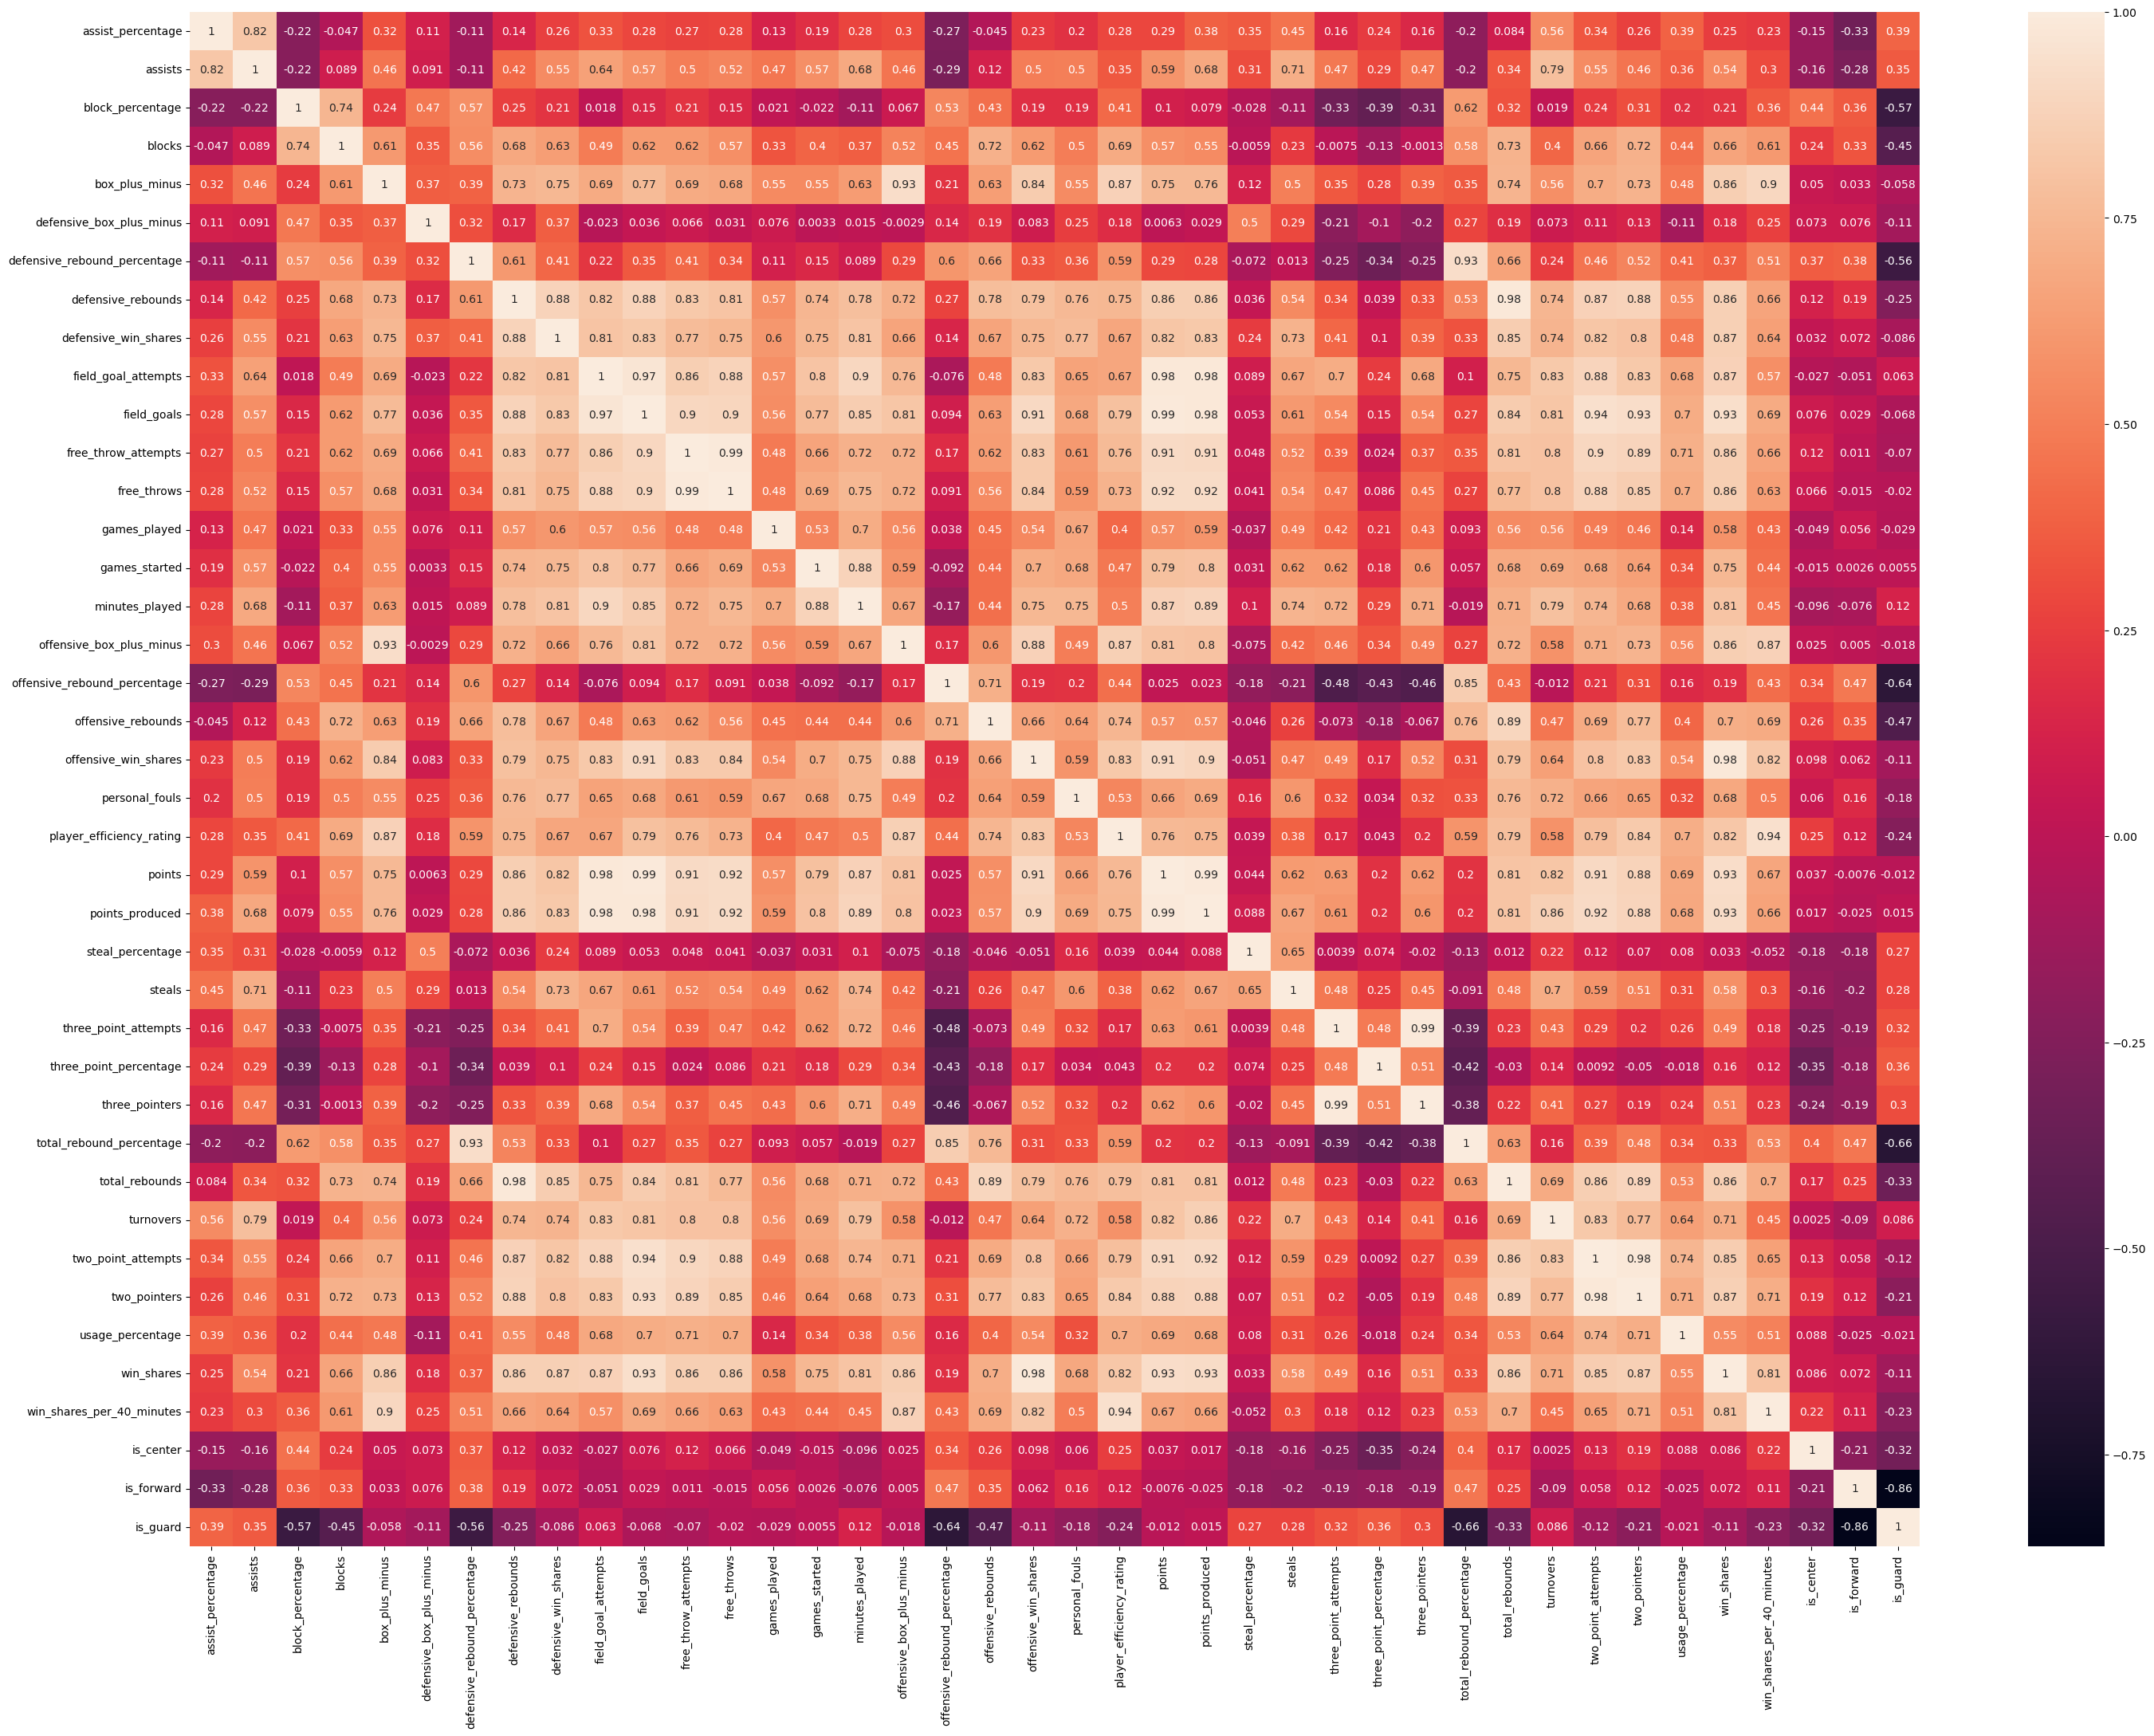

In [10]:
plt.figure(figsize=(35, 25))
sns.heatmap(data=player_df.corr(), annot=True)

In [11]:
model_data = player_df.drop('name', axis=1)
num_clusters = 12
model = KMeans(n_clusters = num_clusters, random_state = 0).fit(model_data)
labels = model.labels_

In [12]:
player_groups = pd.DataFrame(data = {'name': player_df['name'], 'group': labels})
groups = {}

for group in range(num_clusters):
    groups[f"Group {group+1}"] = list(player_groups.query(f"group == {group}")['name'])
    
for group in groups:
    print(f"{group}:\n")
    print(groups[group], "\n\n\n")

Group 1:

['Jacob Grandison', "Da'Monte Williams", 'Parker Stewart', 'Miller Kopp', 'Filip Rebraca', 'Joey Hauser', 'C.J. Wilcher', 'Lat Mayen', 'Ty Berry', 'Robbie Beran', 'Jamari Wheeler', 'Myles Dread', 'Eric Hunter Jr.', 'Mason Gillis', 'Caleb McConnell'] 



Group 2:

['Andre Curbelo', 'Jordan Geronimo', 'Tamar Bates', 'Rob Phinisee', 'Trey Galloway', 'Payton Sandfort', 'Ahron Ulis', 'Ian Martinez', 'Terrance Williams II', 'Brandon Johns Jr', 'Frankie Collins', 'Trey McGowens', 'Eduardo Andre', 'Elyjah Williams', 'Cedric Russell', 'Meechie Johnson Jr.', 'Eugene Brown III', 'Dallion Johnson', 'Greg Lee', 'Jaheam Cornwall', 'Caleb Furst', 'Brandon Newman', 'Aundre Hyatt', 'Mawot Mag', 'Chris Vogt'] 



Group 3:

['Alfonso Plummer', 'Fatts Russell', 'Eric Ayala', 'Donta Scott', 'Gabe Brown', 'Eli Brooks', 'Jamison Battle', 'Payton Willis', 'Bryce McGowens', 'Boo Buie', 'Jalen Pickett', 'Ron Harper Jr.', 'Brad Davison'] 



Group 4:

['Patrick McCaffery', 'Malik Hall', 'Tyson Walker',